# Food Prices - Final Project
----

### Summary
This notebook shows the analysis  of the time series that will be used in the deep learning algorithms for predicting `prices and production of Tomatoes`, considering the information from Mexico available in http://www.fao.org/faostat/en/.

----

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from dateutil.parser import parse 
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose

__References__

Mastering Python for Finance - Second Edition by James Ma Weiming 
Publisher: Packt Publishing
Release Date: April 2019
ISBN: 9781789346466

https://www.machinelearningplus.com/time-series/time-series-analysis-python/

In [4]:
price_df = pd.read_csv('../Resources/Prices_tomatoes_st.csv', parse_dates=['Date'], index_col='Date')
prod_df = pd.read_csv('../Resources/Production_Tomatoes_st.csv', parse_dates=['Date'], index_col='Date')

__Stationary and non-stationary time series__

It is important that time series data that will be used for statistical analysis is `stationary` in order to 
perform statistical modeling correctly (prediction or forecasting). 

A `stationary` time series is one whose statistical properties, such as mean, variance, and 
autocorrelation, are constant over time. Conversely, observations on `non-stationary` time 
series data have their statistical properties change over time, mostly likely due to trends, 
seasonality, presence of a unit root, or a combination of all three.

Modeling from non-stationary data may produce unpredictable results (e.g. spurious regression).

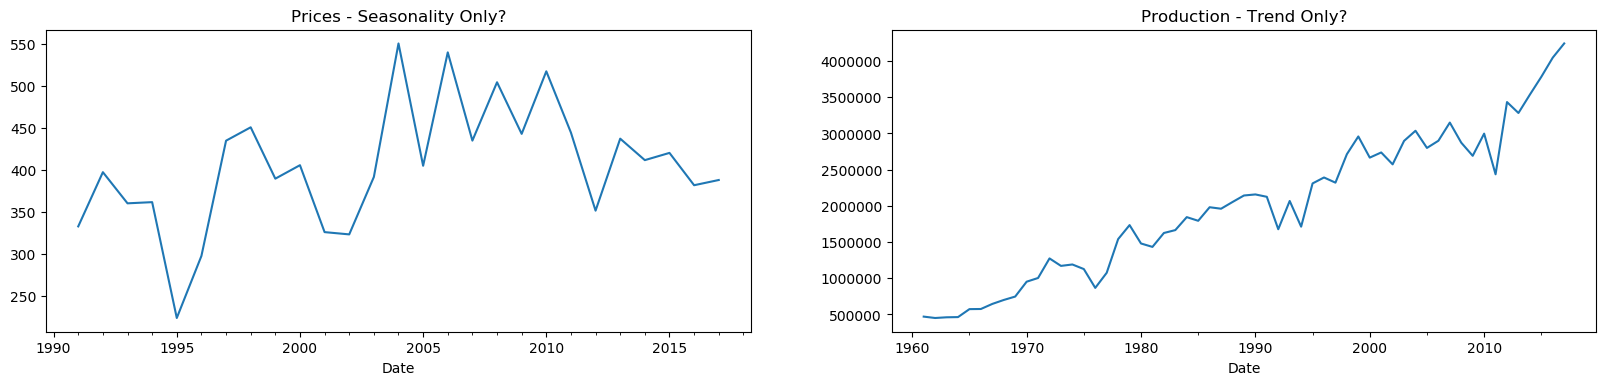

In [6]:
#Checking for stationarity
#Through visualizations: Review a time series graph for obvious indication of trends or seasonality
fig, axes = plt.subplots(1,2, figsize=(20,4), dpi=100)
price_df.plot(title='Prices - Seasonality Only?', legend=False, ax=axes[0])
prod_df.plot(title='Production - Trend Only?', legend=False,  ax=axes[1])

__Prices__

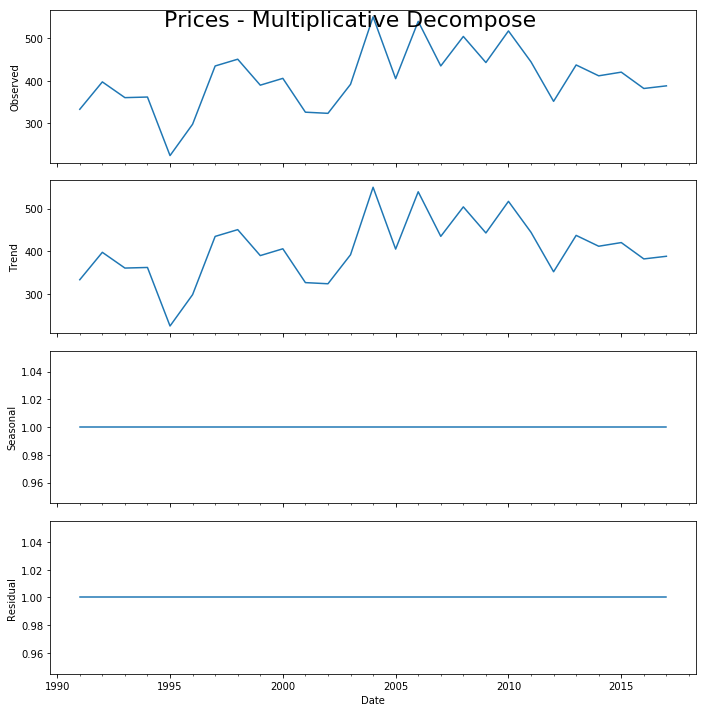

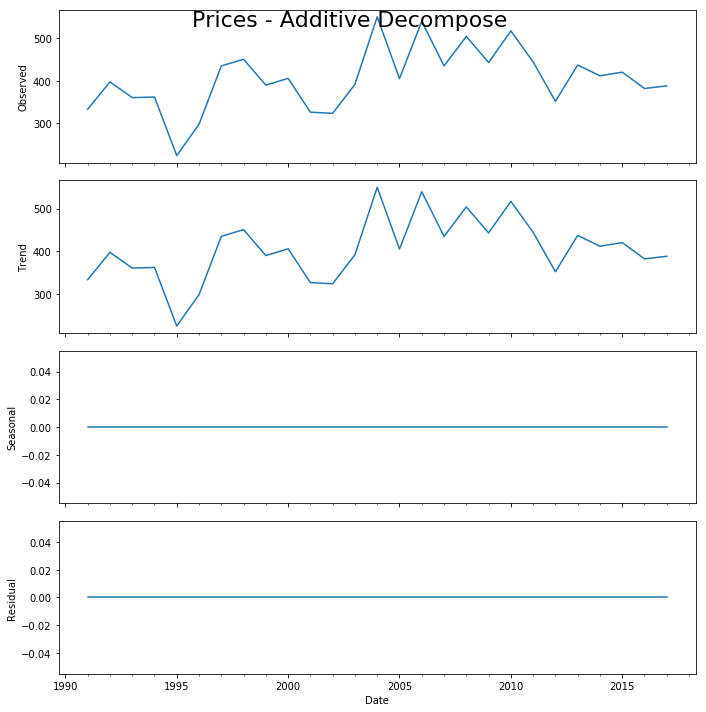

In [7]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(price_df['Price'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(price_df['Price'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Prices - Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Prices - Additive Decompose', fontsize=22)
plt.show()

In [8]:
# Extract the Components
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
1991-12-31,1.0,333.0,1.0,333.0
1992-12-31,1.0,397.4,1.0,397.4
1993-12-31,1.0,360.4,1.0,360.4
1994-12-31,1.0,361.8,1.0,361.8
1995-12-31,1.0,224.2,1.0,224.2


In [34]:
# Checking for stationarity. Test to check if stationarity expectations have been met or violated.
# Through statistical tests: Use statistical tests such as the Augmented Dickey-Fuller - ADF Test or 
# Kwiatkowski-Phillips-Schmidt-Shin – KPSS test 

# ADF Test
result = adfuller(price_df.Price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(price_df.Price.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.471656768274777
p-value: 0.008745553014180653
Critical Values:
   1%, -3.7112123008648155
Critical Values:
   5%, -2.981246804733728
Critical Values:
   10%, -2.6300945562130176

KPSS Statistic: 0.254694
p-value: 0.100000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


C:\Users\bkachava\Anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


An `Augmented Dickey-Fuller Test (ADF)` is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. 

A null hypothesis is formed on the unit root test to determine how strongly time series data is affected by a trend. __By accepting the null hypothesis, we accept the evidence that the time series data is non-stationary.__ By rejecting the null hypothesis, or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process.

This process is also known as trend-stationary. Values of the ADF test statistic are negative. __Lower values of ADF indicates stronger rejection of the null hypothesis.__

The hypothesis can then be formulated as follows:

- Null hypothesis, H0: If failed to be rejected, it suggests that the time series contains a unit root and is non-stationary
- Alternate hypothesis, H1: If H0 is rejected, it suggests that the time series does not contain a unit root and is stationary

To accept or reject the null hypothesis, we use the __p-value__. We reject the null hypothesis if the p-value falls below a threshold value such as 5% or even 1%. We can fail to reject the null hypothesis if the p-value is above this threshold value and consider the time series as non-stationary. In other words, if our threshold value is 5%, or 0.05, note the following:

p-value > 0.05: We fail to reject the null hypothesis H0 and conclude that the data has a unit root and is non-stationary

__p-value ≤ 0.05: We reject the null hypothesis H0 and conclude that the data does not contain a unit root and is stationary__

`p-value: 0.008745553014180653`

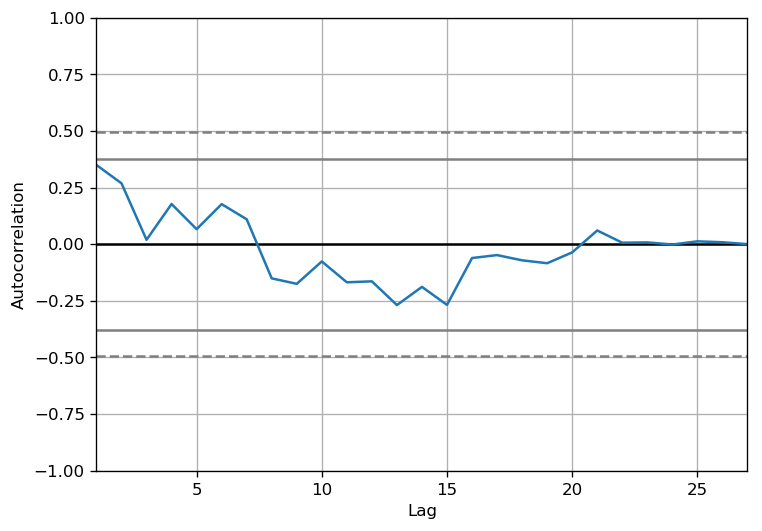

In [10]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':120})
autocorrelation_plot(price_df.Price.tolist())

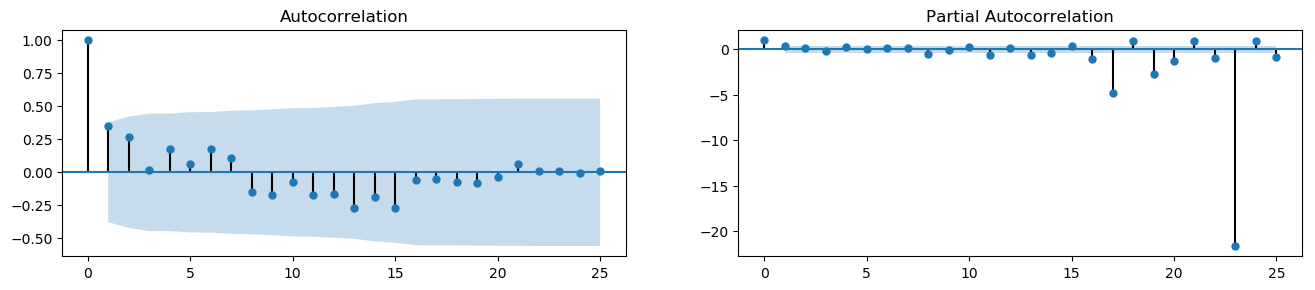

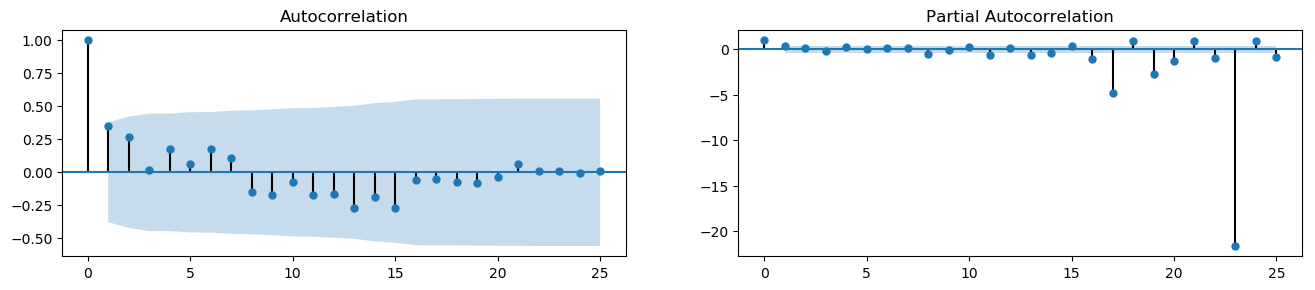

In [28]:
# Calculate ACF and PACF upto 25 lags
acf_25 = acf(price_df.Price, nlags=25)
pacf_25 = pacf(price_df.Price, nlags=25)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(price_df.Price.tolist(), lags=25, ax=axes[0])
plot_pacf(price_df.Price.tolist(), lags=25, ax=axes[1])

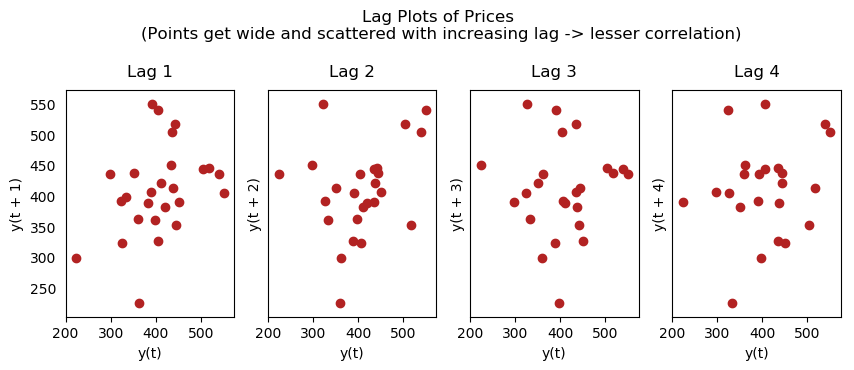

In [29]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(price_df.Price, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Prices \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15) 

plt.show()


__Production__

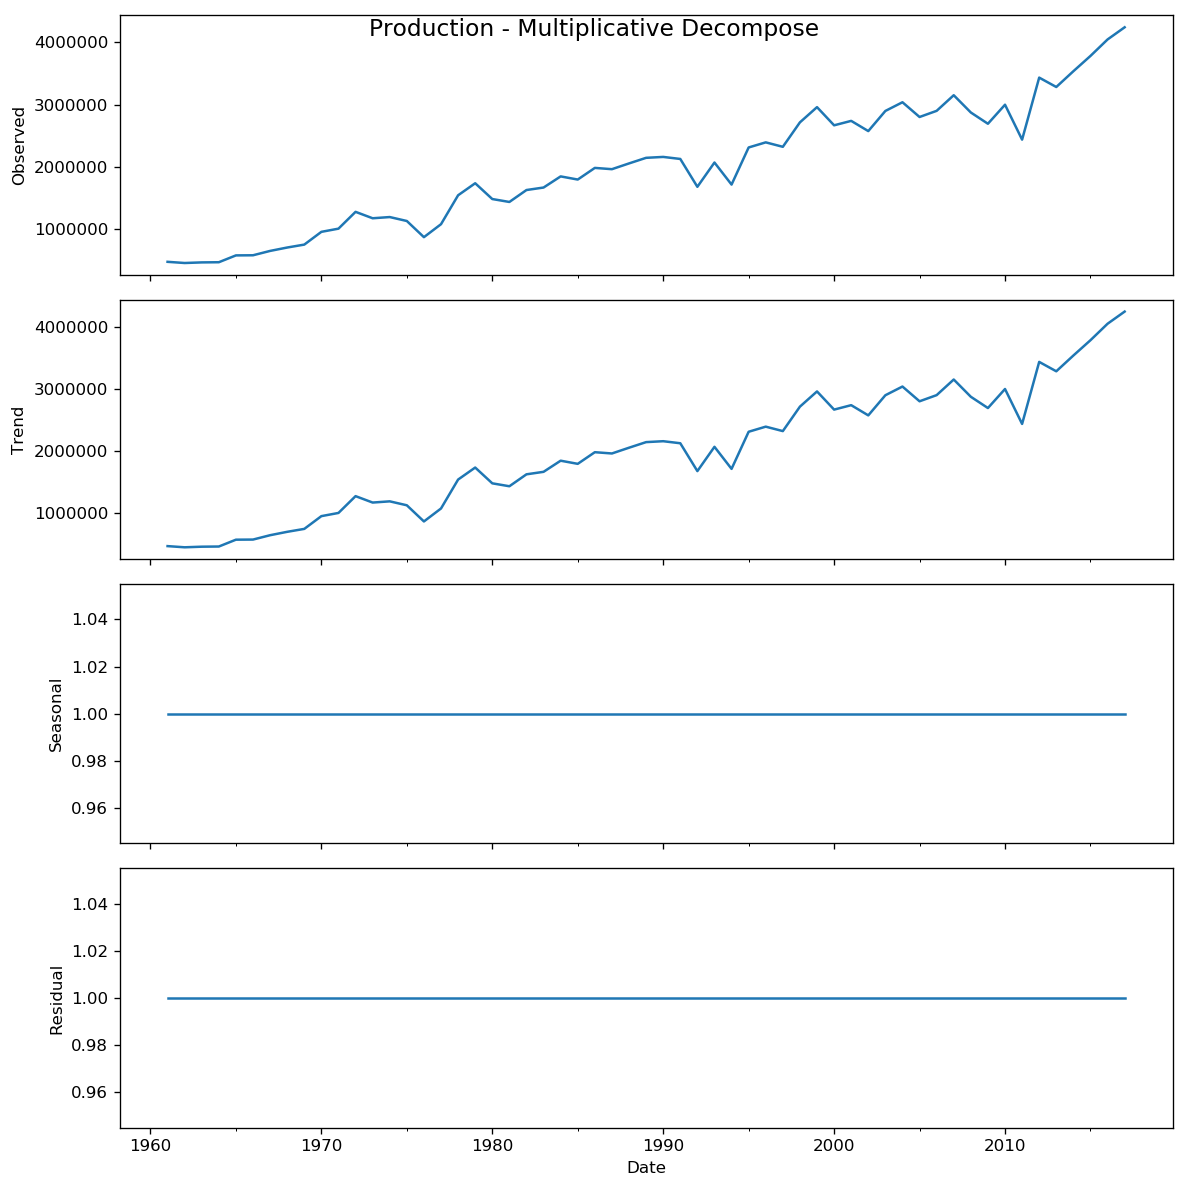

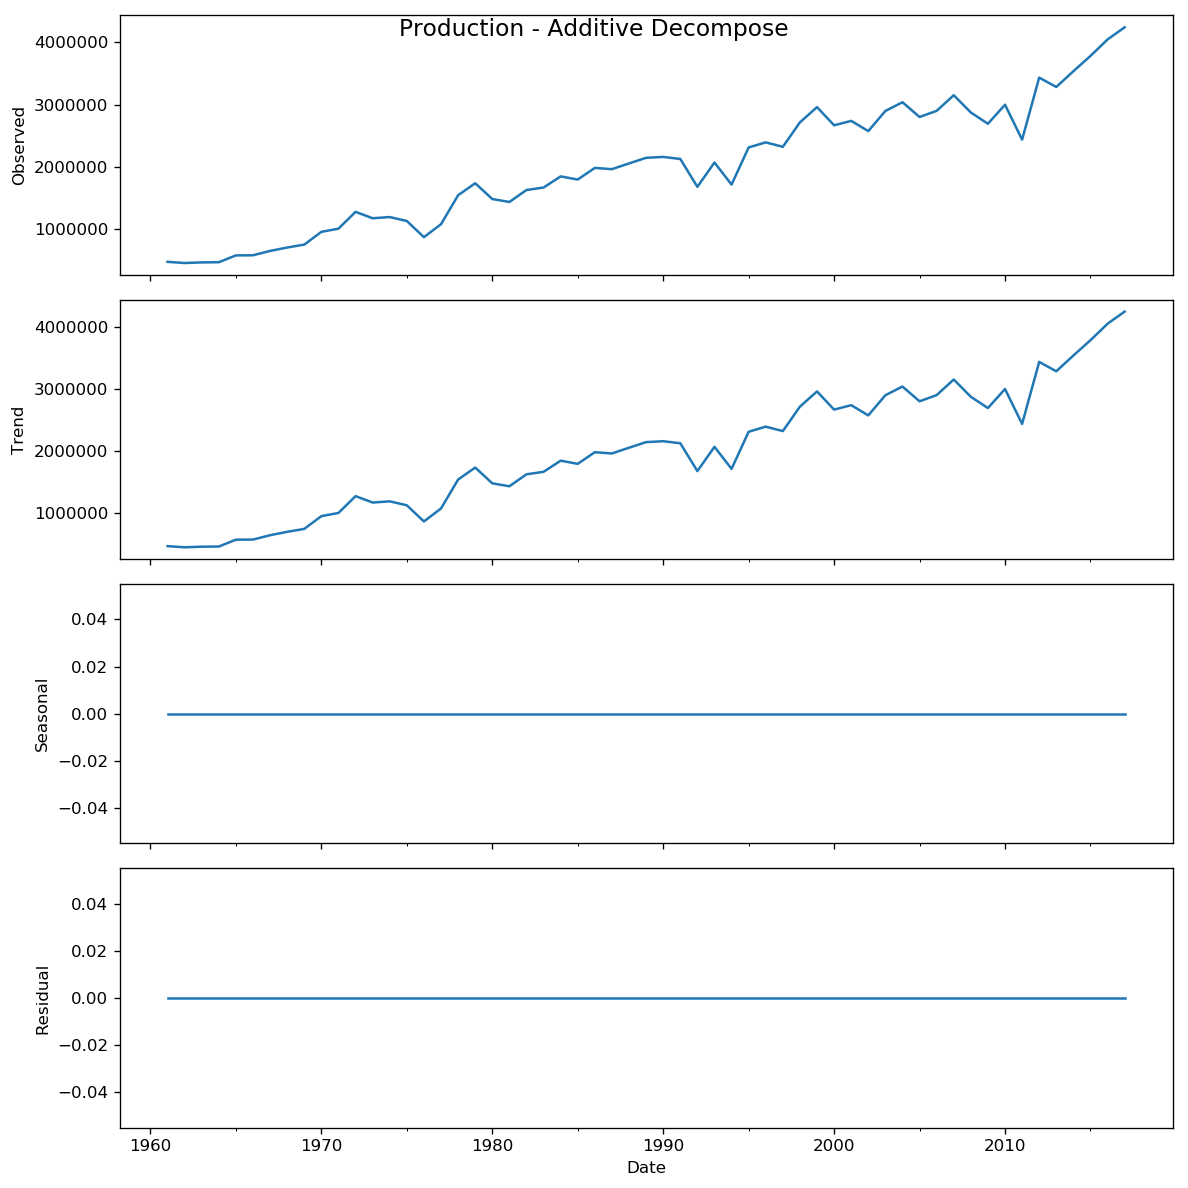

In [12]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(prod_df['Production'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(prod_df['Production'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Production - Multiplicative Decompose', fontsize=14)
result_add.plot().suptitle('Production - Additive Decompose', fontsize=14)
plt.show()

In [13]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
Date,,,,
1961-12-31,1.0,470527.0,1.0,470527
1962-12-31,1.0,451502.0,1.0,451502
1963-12-31,1.0,461191.0,1.0,461191
1964-12-31,1.0,463992.0,1.0,463992
1965-12-31,1.0,573919.0,1.0,573919


In [33]:
# ADF Test
result = adfuller(prod_df.Production.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(prod_df.Production.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.3945615035912149
p-value: 0.9812904185616504
Critical Values:
   1%, -3.5552728880540942
Critical Values:
   5%, -2.9157312396694217
Critical Values:
   10%, -2.5956695041322315

KPSS Statistic: 0.611828
p-value: 0.021561
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739


__p-value > 0.05: We fail to reject the null hypothesis H0 and conclude that the data has a unit root and is non-stationary__

`p-value: 0.9812904185616504`

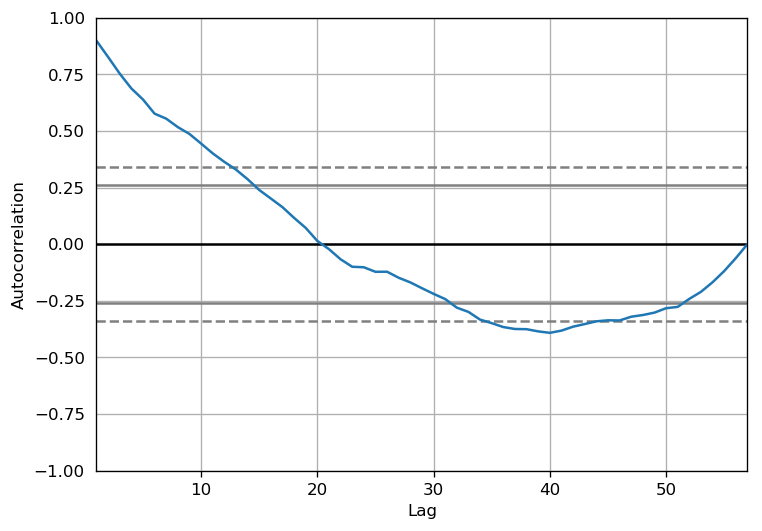

In [38]:
# Draw Plot
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':120})
autocorrelation_plot(prod_df.Production.tolist())

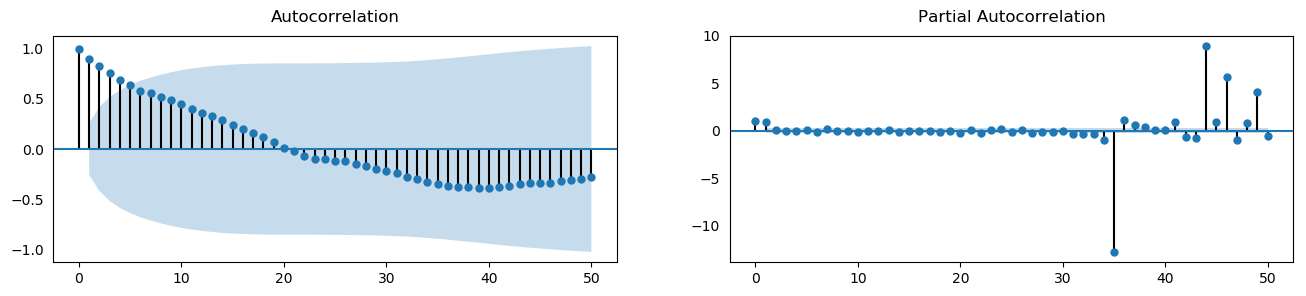

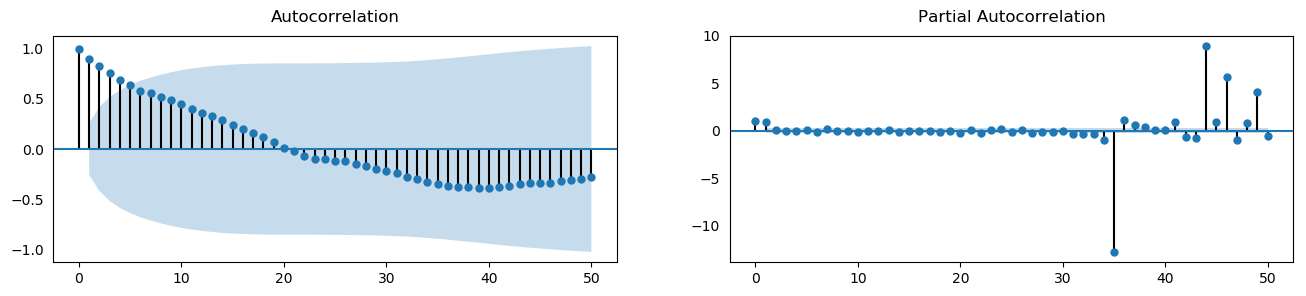

In [40]:
# Calculate ACF and PACF upto 25 lags
acf_50 = acf(prod_df.Production, nlags=50)
pacf_50 = pacf(prod_df.Production, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(prod_df.Production.tolist(), lags=50, ax=axes[0])
plot_pacf(prod_df.Production.tolist(), lags=50, ax=axes[1])

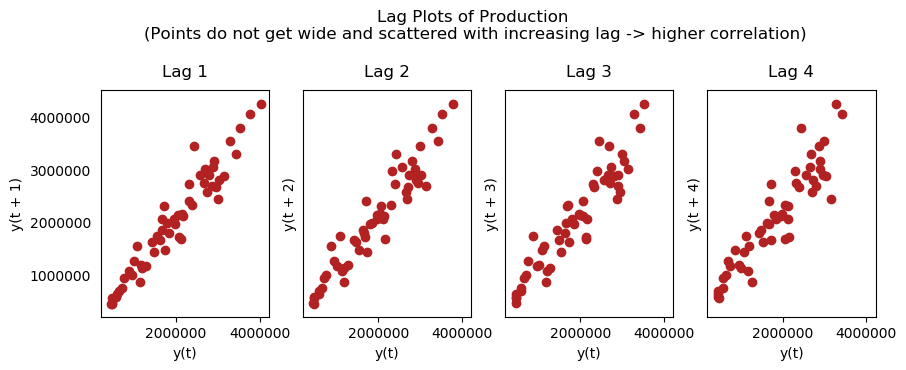

In [42]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(prod_df.Production, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Production \n(Points do not get wide and scattered with increasing lag -> higher correlation)\n', y=1.15) 
plt.show()

Text(0.5, 1.0, 'Production detrended by subtracting the least squares fit')

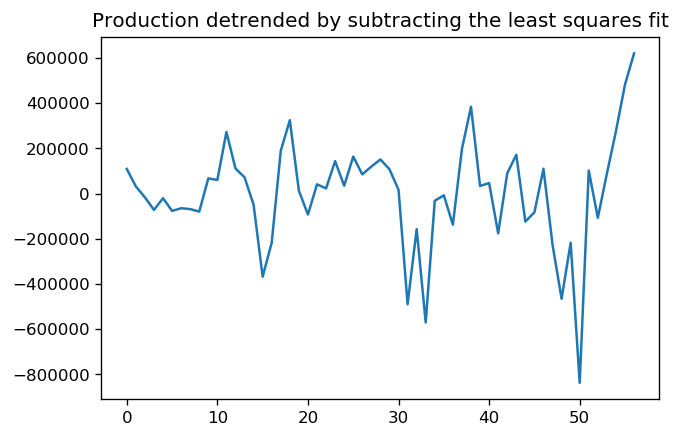

In [27]:
# Using scipy: Subtract the line of best fit
detrended = signal.detrend(prod_df.Production.values)
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
plt.plot(detrended)
plt.title('Production detrended by subtracting the least squares fit', fontsize=12)

In [20]:
detrended

array([ 109453.90018149,   32189.86239305,  -16360.17539539,
        -71798.21318382,  -20110.25097226,  -76413.28876069,
        -64575.32654913,  -68274.36433757,  -79475.402126  ,
         67551.56008556,   60580.52229712,  272689.48450869,
        111189.44672025,   72446.40893181,  -49182.62885662,
       -367465.66664506, -217034.7044335 ,  189868.25777807,
        324994.21998963,   12810.18220119,  -92482.85558724,
         41229.10662432,   23158.06883588,  143915.03104745,
         35105.99325901,  164064.95547057,   85364.91768214,
        119747.8798937 ,  151512.84210526,  107899.80431683,
         16907.76652839, -489363.27126005, -157012.30904848,
       -570091.34683692,  -31232.38462536,   -7409.42241379,
       -137098.46020223,  197902.50200933,  384443.4642209 ,
         33884.42643246,   47005.38864402, -175501.64914441,
         90264.31306715,  171913.27527871, -123475.76250972,
        -82676.80029816,  110284.1619134 , -225637.87587503,
       -465151.91366347,

Text(0.5, 1.0, 'Production detrended by subtracting the trend component')

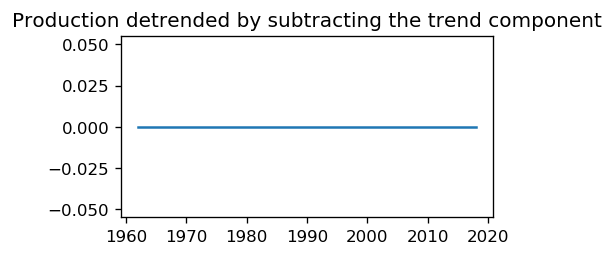

In [24]:
# Using statmodels: Subtracting the Trend Component.
result_mul = seasonal_decompose(prod_df.Production, model='multiplicative', extrapolate_trend='freq')
detrended = prod_df.Production.values - result_mul.trend
plt.rcParams.update({'figure.figsize':(4,2), 'figure.dpi':120})
plt.plot(detrended)
plt.title('Production detrended by subtracting the trend component', fontsize=12)

In [25]:
detrended

Date
1961-12-31    0.0
1962-12-31    0.0
1963-12-31    0.0
1964-12-31    0.0
1965-12-31    0.0
1966-12-31    0.0
1967-12-31    0.0
1968-12-31    0.0
1969-12-31    0.0
1970-12-31    0.0
1971-12-31    0.0
1972-12-31    0.0
1973-12-31    0.0
1974-12-31    0.0
1975-12-31    0.0
1976-12-31    0.0
1977-12-31    0.0
1978-12-31    0.0
1979-12-31    0.0
1980-12-31    0.0
1981-12-31    0.0
1982-12-31    0.0
1983-12-31    0.0
1984-12-31    0.0
1985-12-31    0.0
1986-12-31    0.0
1987-12-31    0.0
1988-12-31    0.0
1989-12-31    0.0
1990-12-31    0.0
1991-12-31    0.0
1992-12-31    0.0
1993-12-31    0.0
1994-12-31    0.0
1995-12-31    0.0
1996-12-31    0.0
1997-12-31    0.0
1998-12-31    0.0
1999-12-31    0.0
2000-12-31    0.0
2001-12-31    0.0
2002-12-31    0.0
2003-12-31    0.0
2004-12-31    0.0
2005-12-31    0.0
2006-12-31    0.0
2007-12-31    0.0
2008-12-31    0.0
2009-12-31    0.0
2010-12-31    0.0
2011-12-31    0.0
2012-12-31    0.0
2013-12-31    0.0
2014-12-31    0.0
2015-12-31    0.0
2016-

[]

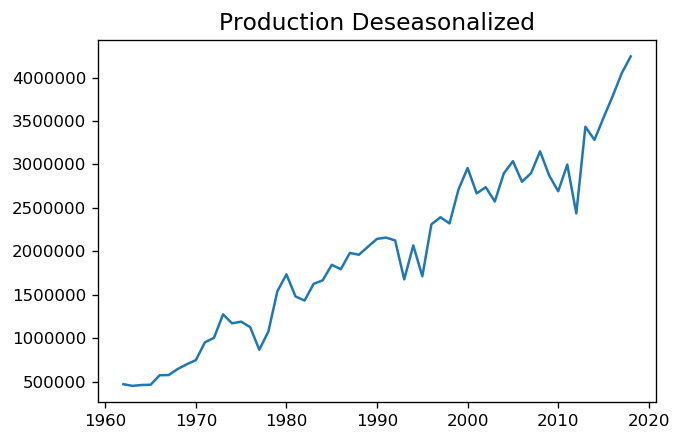

In [16]:
# Subtracting the Trend Component.
# Time Series Decomposition
result_mul = seasonal_decompose(prod_df['Production'], model='multiplicative', extrapolate_trend='freq')

# Deseasonalize
deseasonalized = prod_df.Production.values / result_mul.seasonal

# Plot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
plt.plot(deseasonalized)
plt.title('Production Deseasonalized', fontsize=14)
plt.plot()

In [17]:
deseasonalized

Date
1961-12-31     470527.0
1962-12-31     451502.0
1963-12-31     461191.0
1964-12-31     463992.0
1965-12-31     573919.0
1966-12-31     575855.0
1967-12-31     645932.0
1968-12-31     700472.0
1969-12-31     747510.0
1970-12-31     952776.0
1971-12-31    1004044.0
1972-12-31    1274392.0
1973-12-31    1171131.0
1974-12-31    1190627.0
1975-12-31    1127237.0
1976-12-31     867193.0
1977-12-31    1075863.0
1978-12-31    1541005.0
1979-12-31    1734370.0
1980-12-31    1480425.0
1981-12-31    1433371.0
1982-12-31    1625322.0
1983-12-31    1665490.0
1984-12-31    1844486.0
1985-12-31    1793916.0
1986-12-31    1981114.0
1987-12-31    1960653.0
1988-12-31    2053275.0
1989-12-31    2143279.0
1990-12-31    2157905.0
1991-12-31    2125152.0
1992-12-31    1677120.0
1993-12-31    2067710.0
1994-12-31    1712870.0
1995-12-31    2309968.0
1996-12-31    2392030.0
1997-12-31    2320580.0
1998-12-31    2713820.0
1999-12-31    2958600.0
2000-12-31    2666280.0
2001-12-31    2737640.0
2002-12-31 

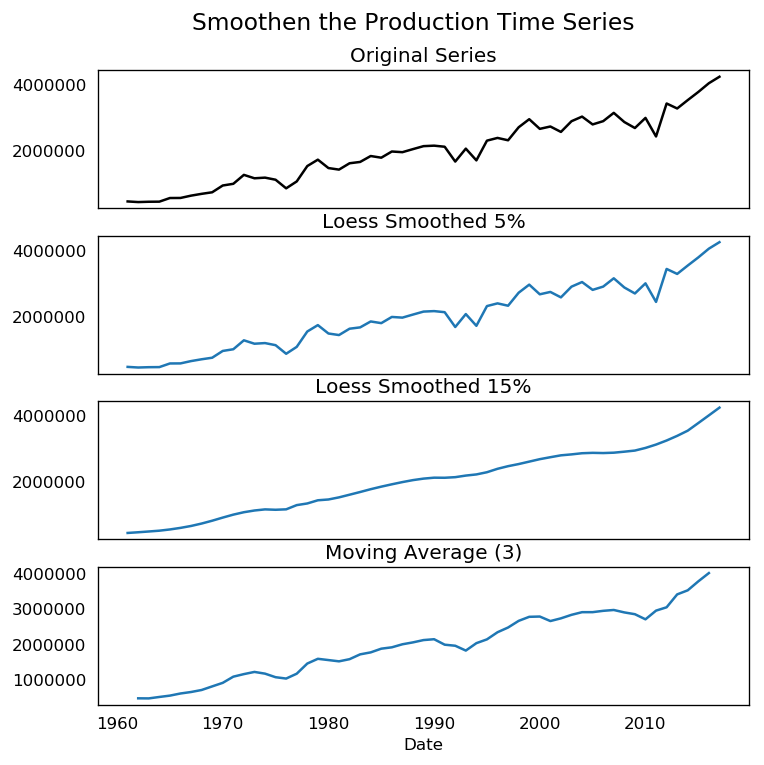

In [44]:
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = prod_df.Production.rolling(3, center=True, closed='both').mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(prod_df.Production, np.arange(len(prod_df.Production)), frac=0.05)[:, 1], index=prod_df.index, columns=['Production'])
df_loess_15 = pd.DataFrame(lowess(prod_df.Production, np.arange(len(prod_df.Production)), frac=0.15)[:, 1], index=prod_df.index, columns=['Production'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
prod_df['Production'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['Production'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['Production'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('Smoothen the Production Time Series', y=0.95, fontsize=14)
plt.show()

__Production detrended data__

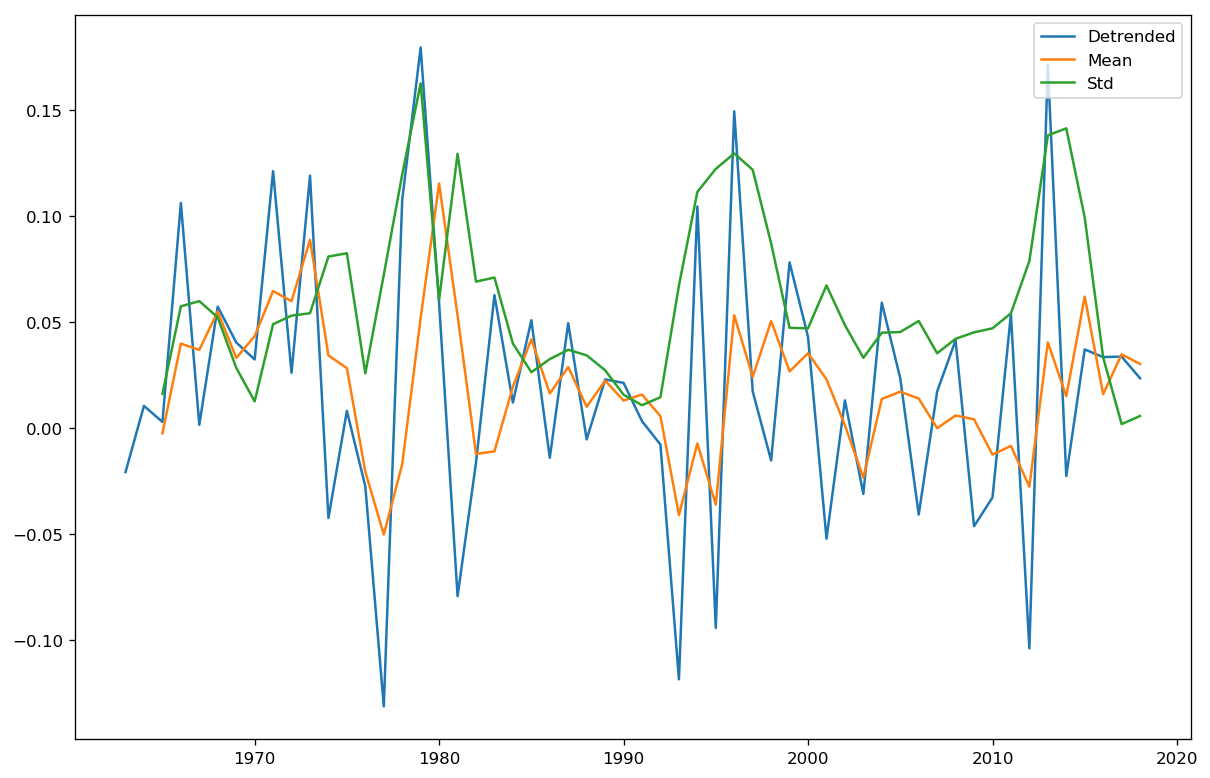

In [29]:
prod_log_df = np.log(prod_df)
df_log_ma= prod_log_df.rolling(2).mean()
df_detrend = prod_log_df - df_log_ma
df_detrend.dropna(inplace=True)

# Mean and standard deviation of detrended data
df_detrend_rolling = df_detrend.rolling(3)
df_detrend_ma = df_detrend_rolling.mean()
df_detrend_std = df_detrend_rolling.std()

# Plot
plt.figure(figsize=(12, 8))
plt.plot(df_detrend, label='Detrended')
plt.plot(df_detrend_ma, label='Mean')
plt.plot(df_detrend_std, label='Std')
plt.legend(loc='upper right');

In [35]:
df_detrend

,Production
Date,
1962-12-31,-0.020637
1963-12-31,0.010616
1964-12-31,0.003028
1965-12-31,0.106310
1966-12-31,0.001684
1967-12-31,0.057419
1968-12-31,0.040530
1969-12-31,0.032497
1970-12-31,0.121316


In [39]:
result = adfuller(df_detrend.Production)    
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -9.492388070475732
p-value: 3.623478276899789e-16
Critical Values:
   1%, -3.5552728880540942
Critical Values:
   5%, -2.9157312396694217
Critical Values:
   10%, -2.5956695041322315


The p-value for this detrended data (3.623478276899789e-16) is less than 0.05. 

ADF test statistic is lower than all critical values. We can reject the null hypothesis and say that __this data is stationary.__

In [41]:
# Export file as a CSV, without the Pandas index, but with the header
df_detrend.reset_index(inplace=True)
df_detrend.to_csv("../Resources/Production_Tomatoes_wst.csv", index=False, header=True)